In [74]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection

In [229]:



def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)


def plot_curve(X):
    """
    Plot a curve given by the points in X.

    Parameters
    ----------
    X : torch.Tensor
        The points on the curve. Should be a 2D tensor with shape (n_points, 3).
        each point represents a (t, x, y) value.
    """

    # -------------- Create and show plot --------------
    # Some arbitrary function that gives x, y, and color values
    t = X[:, 0].numpy()
    x = X[:, 1].numpy()
    y = X[:, 2].numpy()
    color = np.linspace(0, int(np.max(t)) + 1,t.size )  # color by t value

    # Create a figure and plot the line on it
    fig1, ax1 = plt.subplots()
    lines = colored_line(x, y, color, ax1,  cmap="plasma")
    fig1.colorbar(lines)  # add a color legend

    # Set the axis limits and tick positions
    ax1.set_xlim(np.min(x), np.max(x))
    ax1.set_ylim(np.min(y), np.max(y))
    # ax1.set_xticks((-1, 0, 1))
    # ax1.set_yticks((-1, 0, 1))
    ax1.set_title("worm movement")

    plt.show()

In [148]:
aa=torch.tensor([[0,0],[1,1],[2,1]],dtype=torch.float32)
torch.arccos(torch.dot(aa[-1]/torch.norm(aa[-1]),torch.tensor([1,0],dtype=torch.float32)))

# plot_curve(aa)

tensor(0.4636)

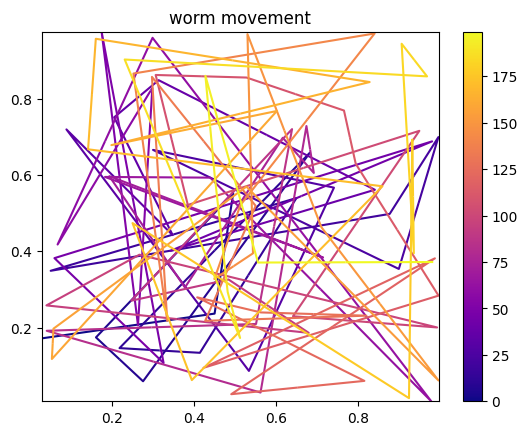

In [237]:
# dummy data
# x = torch.tensor([[[i*num*k for i in range(200)] for k in range(10)]for num in range(5)], dtype=torch.float32).reshape(5,10, 100, 2)
x = torch.rand(5,10, 100, 2)
x[2][2]
def append_t(x):
    t=torch.linspace(0, (x.shape[0]-1)*2, x.shape[0] )
    return torch.cat((t.reshape(-1,1), x), dim=1)
# t=torch.linspace(0, (x[2][2].shape[0]-1)*2, x[2][2].shape[0] )
# x_with_t=torch.cat((t.reshape(-1,1), x[2][2]), dim=1)
plot_curve(append_t(x[1][2]))


In [228]:
final_x[2][2]

tensor([[   0.0000,    0.0000],
        [   0.0000,   11.3137],
        [   0.0000,   22.6274],
        [   0.0000,   33.9411],
        [   0.0000,   45.2548],
        [   0.0000,   56.5685],
        [   0.0000,   67.8822],
        [   0.0000,   79.1960],
        [   0.0000,   90.5097],
        [   0.0000,  101.8234],
        [   0.0000,  113.1371],
        [   0.0000,  124.4508],
        [   0.0000,  135.7645],
        [   0.0000,  147.0782],
        [   0.0000,  158.3919],
        [   0.0000,  169.7056],
        [   0.0000,  181.0193],
        [   0.0000,  192.3330],
        [   0.0000,  203.6467],
        [   0.0000,  214.9605],
        [   0.0000,  226.2742],
        [   0.0000,  237.5879],
        [   0.0000,  248.9016],
        [   0.0000,  260.2153],
        [   0.0000,  271.5290],
        [   0.0000,  282.8427],
        [   0.0000,  294.1564],
        [   0.0000,  305.4701],
        [   0.0000,  316.7838],
        [   0.0000,  328.0975],
        [   0.0000,  339.4113],
        

In [117]:
last_frame = torch.roll(x, 1, 2) 
delta_xy = (x - last_frame)[:,1:,:]
speed = torch.norm(delta_xy, dim=3)
avg_speed_single_period = torch.mean(speed, dim=2)
avg_speed = torch.mean(avg_speed_single_period, dim=1)
print(avg_speed_single_period)

def avg_first_k_periods(x, k):
    
    avg_single_period = torch.mean(x, dim=2)
    avg = torch.mean(avg_single_period[:,:k], dim=1)
    return avg

def var_single_period(x):
    return torch.var(x, dim=2)
     
def var_first_k_periods(x, k):
    avg_single_period = torch.mean(x, dim=2)
    avg = torch.var(avg_single_period[:,:k], dim=1)
    return avg

def avg_across_periods(x,start,end):
    avg_single_period = torch.mean(x, dim=2)
    var = torch.mean(avg_single_period[:,start:end], dim=1)
    return var

avg_speed_first_2_periods = avg_first_k_periods(speed, 2)



tensor([[  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000],
        [  5.6003,  11.2006,  16.8009,  22.4011,  28.0014,  33.6017,  39.2020,
          44.8023,  50.4026],
        [ 11.2006,  22.4011,  33.6017,  44.8023,  56.0028,  67.2034,  78.4040,
          89.6046, 100.8051],
        [ 16.8009,  33.6017,  50.4026,  67.2034,  84.0043, 100.8051, 117.6060,
         134.4069, 151.2077],
        [ 22.4011,  44.8023,  67.2034,  89.6046, 112.0057, 134.4069, 156.8080,
         179.2092, 201.6103]])


In [60]:
acceleration = speed - torch.roll(speed, 1, 2)

avg_acc_first_2_periods = avg_first_k_periods(acceleration, 2)


In [67]:
threshold = 0
active_frames = speed > threshold
active_time = torch.sum(active_frames, dim=2)
avg_active_time = torch.mean(active_time, dim=1,dtype=torch.float32)


In [72]:
sharp_turn = torch.sum(torch.sum(delta_xy*torch.roll(delta_xy, 1, 2),dim=3)[:,:,2:]<0,dim=2)
sharp_turn

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [176]:
torch.arctan(aa[-1][1]/aa[-1][0])

tensor(0.4636)

In [177]:
torch.arccos(torch.dot(aa[-1]/torch.norm(aa[-1]),torch.tensor([1,0],dtype=torch.float32)))

tensor(0.4636)

In [165]:
x_shifted

tensor([[[[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         ...,

         [[0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00],
          [0.0000

In [215]:
rotation_angle.shape

torch.Size([5, 10, 1])

In [231]:
x_shifted = x-x[:,:,0,:].unsqueeze(2)
rotation_angle = -torch.arctan(x_shifted[:,:,-1,1]/x_shifted[:,:,-1,0]).unsqueeze(2)
# angles = torch.arctan(x_shifted[:,:,:,1]/x_shifted[:,:,:,0])
# rotation_angles = end_angle - angles
cos_rot = torch.cos(rotation_angle).unsqueeze(3)
sin_rot = torch.sin(rotation_angle).unsqueeze(3)
rotated_x = torch.sum(x_shifted.unsqueeze(4)*torch.cat((cos_rot, -sin_rot,sin_rot,cos_rot), dim=3).reshape(x_shifted.shape[0],x_shifted.shape[1],1,2,2),axis=4)

final_x=torch.where(torch.isnan(rotated_x), x_shifted, rotated_x)

tensor([[[nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         ...,
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan],
         [nan, nan, nan,  ..., nan, nan, nan]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[nan, nan, nan,  ..., nan, nan, nan],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  

In [233]:
from frechetdist import frdist

frechet_dist = torch.zeros(x.shape[0], x.shape[1]-1)
for i in range(x.shape[0]):
    for period in range(x.shape[1]-1):
        frechet_dist[i][period] = frdist(final_x[i][period], final_x[i][period+1])

frechet_dist


tensor([[   0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
            0.0000,    0.0000,    0.0000],
        [ 280.0143,  280.0143,  280.0143,  280.0143,  280.0143,  280.0143,
          280.0143,  280.0143,  280.0142],
        [ 560.0286,  560.0286,  560.0286,  560.0286,  560.0286,  560.0286,
          560.0286,  560.0286,  560.0283],
        [ 840.0428,  840.0428,  840.0427,  840.0430,  840.0430,  840.0425,
          840.0430,  840.0430,  840.0430],
        [1120.0571, 1120.0571, 1120.0571, 1120.0571, 1120.0571, 1120.0571,
         1120.0571, 1120.0571, 1120.0566]])